In [67]:
!pip install pyspark

In [68]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
spark = SparkSession.builder.appName("ResultManagement").getOrCreate()
df=pd.read_csv('students_data.csv')

In [69]:
 df_spark = spark.createDataFrame(df)

In [70]:
df_spark.printSchema()
df_spark.describe().show()


root
 |-- StudentID: long (nullable = true)
 |-- Name: string (nullable = true)
 |-- Electronics: long (nullable = true)
 |-- Programming: long (nullable = true)
 |-- Database: long (nullable = true)
 |-- Data Science: long (nullable = true)
 |-- Mathematics: long (nullable = true)
 |-- DSA: long (nullable = true)

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|         StudentID|             Name|       Electronics|       Programming|          Database|      Data Science|       Mathematics|               DSA|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             10000|            10000|             10000|             10000|             10000|             10000|             10000|             10000|
|   mean|            5000.5|           

# Average Marks Per Subject

In [71]:
from pyspark.sql.functions import avg, col

subjects = ["Electronics", "Programming", "Database", "Data Science", "Mathematics", "DSA"]

df_spark.select([avg(col(subject)).alias(f"Avg_{subject}") for subject in subjects]).show()

+---------------+---------------+------------+----------------+---------------+-------+
|Avg_Electronics|Avg_Programming|Avg_Database|Avg_Data Science|Avg_Mathematics|Avg_DSA|
+---------------+---------------+------------+----------------+---------------+-------+
|        64.8055|        64.8523|     65.0064|         64.5985|        64.9913|65.3627|
+---------------+---------------+------------+----------------+---------------+-------+



# Highest & Lowest Marks Per Subject

In [72]:
from pyspark.sql.functions import max, min

df_spark.select([max(col(subject)).alias(f"Max_{subject}") for subject in subjects]).show()

df_spark.select([min(col(subject)).alias(f"Min_{subject}") for subject in subjects]).show()

+---------------+---------------+------------+----------------+---------------+-------+
|Max_Electronics|Max_Programming|Max_Database|Max_Data Science|Max_Mathematics|Max_DSA|
+---------------+---------------+------------+----------------+---------------+-------+
|            100|            100|         100|             100|            100|    100|
+---------------+---------------+------------+----------------+---------------+-------+

+---------------+---------------+------------+----------------+---------------+-------+
|Min_Electronics|Min_Programming|Min_Database|Min_Data Science|Min_Mathematics|Min_DSA|
+---------------+---------------+------------+----------------+---------------+-------+
|             30|             30|          30|              30|             30|     30|
+---------------+---------------+------------+----------------+---------------+-------+



# Pass Percentage (Assuming Pass Mark = 40)

In [73]:
from pyspark.sql.functions import count, when

pass_criteria = 40

pass_counts = df_spark.select([(count(when(col(subject) >= pass_criteria, subject)) * 100 / df_spark.count()).alias(f"Pass_Percentage_{subject}") for subject in subjects])
pass_counts.show()

+---------------------------+---------------------------+------------------------+----------------------------+---------------------------+-------------------+
|Pass_Percentage_Electronics|Pass_Percentage_Programming|Pass_Percentage_Database|Pass_Percentage_Data Science|Pass_Percentage_Mathematics|Pass_Percentage_DSA|
+---------------------------+---------------------------+------------------------+----------------------------+---------------------------+-------------------+
|                      85.49|                      85.59|                   85.55|                       85.66|                      86.27|              86.29|
+---------------------------+---------------------------+------------------------+----------------------------+---------------------------+-------------------+



In [74]:
df_pandas = df_spark.toPandas()

# Visualize Subject-Wise Average Marks

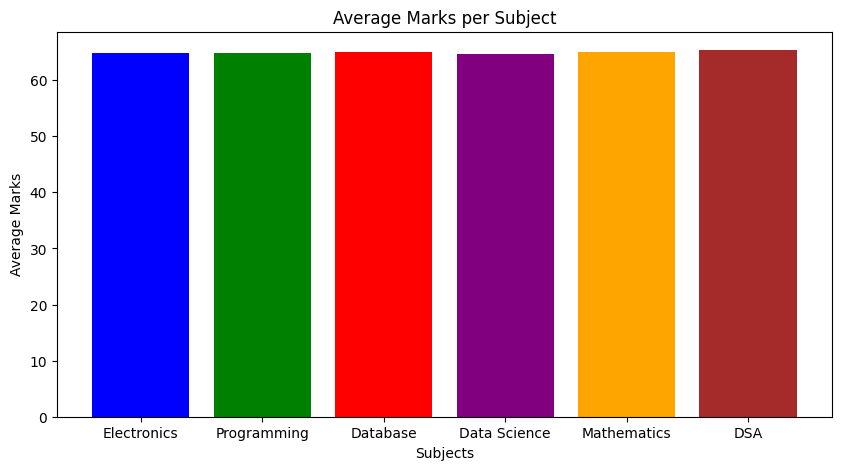

In [75]:

avg_marks = df_pandas[subjects].mean()

plt.figure(figsize=(10, 5))
plt.bar(subjects, avg_marks, color=['blue', 'green', 'red', 'purple', 'orange', 'brown'])
plt.xlabel("Subjects")
plt.ylabel("Average Marks")
plt.title("Average Marks per Subject")
plt.show()


# Average Marks with Respective Grades

In [76]:
from pyspark.sql.functions import when, col
from functools import reduce

df_spark = df_spark.withColumn("Average_Marks",reduce(lambda x, y: x + y, [col(subject) for subject in subjects]) / len(subjects))

df_spark = df_spark.withColumn(
    "Grade",
    when(col("Average_Marks") >= 90, "A")
    .when(col("Average_Marks") >= 80, "B")
    .when(col("Average_Marks") >= 70, "C")
    .when(col("Average_Marks") >= 60, "D")
    .otherwise("Fail")
)

df_spark.select("StudentID", "Name", "Average_Marks", "Grade").show(10)

+---------+---------------+------------------+-----+
|StudentID|           Name|     Average_Marks|Grade|
+---------+---------------+------------------+-----+
|        1|   Joanna Perry|61.666666666666664|    D|
|        2|   Aditya Verma|              65.0|    D|
|        3| Mario Gonzalez|              73.0|    C|
|        4|    Priya Mehta|52.333333333333336| Fail|
|        5|    Ananya Nair|              70.0|    C|
|        6|     James Ward|47.666666666666664| Fail|
|        7|   Ishika Singh|              66.0|    D|
|        8|    Priya Singh| 70.33333333333333|    C|
|        9|Siddharth Verma| 75.83333333333333|    C|
|       10|  Sandra Knight| 79.33333333333333|    C|
+---------+---------------+------------------+-----+
only showing top 10 rows



# Correlation Analysis Between Subjects

In [77]:
df_spark.select([col(subject).cast("double") for subject in subjects]).summary("mean").show()

for sub1 in subjects:
    for sub2 in subjects:
        if sub1 != sub2:
            print(f"Correlation between {sub1} and {sub2}: {df_spark.stat.corr(sub1, sub2)}")

+-------+-----------+-----------+--------+------------+-----------+-------+
|summary|Electronics|Programming|Database|Data Science|Mathematics|    DSA|
+-------+-----------+-----------+--------+------------+-----------+-------+
|   mean|    64.8055|    64.8523| 65.0064|     64.5985|    64.9913|65.3627|
+-------+-----------+-----------+--------+------------+-----------+-------+

Correlation between Electronics and Programming: -0.012322922206599193
Correlation between Electronics and Database: -0.002109304525721397
Correlation between Electronics and Data Science: -0.014612544469481193
Correlation between Electronics and Mathematics: -0.02930087759138294
Correlation between Electronics and DSA: -0.0070280770069872725
Correlation between Programming and Electronics: -0.012322922206599191
Correlation between Programming and Database: 0.00949264595002557
Correlation between Programming and Data Science: 0.013626150424882567
Correlation between Programming and Mathematics: 0.003154775369962

# Find Weak Students (Failed in 2+ Subjects)

In [78]:
from pyspark.sql.functions import when, col
from functools import reduce

df_spark = df_spark.withColumn("Failed_Subjects",reduce(lambda x, y: x + y, [when(col(subject) < 40, 1).otherwise(0) for subject in subjects]))

weak_students = df_spark.filter(col("Failed_Subjects") >= 2)

weak_students.select("StudentID", "Name", "Failed_Subjects").show(10)

+---------+---------------+---------------+
|StudentID|           Name|Failed_Subjects|
+---------+---------------+---------------+
|        4|    Priya Mehta|              3|
|        6|     James Ward|              2|
|       13|    Tina Levine|              3|
|       17|    Priya Patel|              2|
|       27|   Ishika Reddy|              2|
|       28|     Aarav Iyer|              2|
|       33|  Angela Miller|              2|
|       43| Robert Jackson|              2|
|       45|   Aditya Gupta|              3|
|       46|Priya Choudhary|              3|
+---------+---------------+---------------+
only showing top 10 rows



# Performance Distribution (Histogram of Marks)

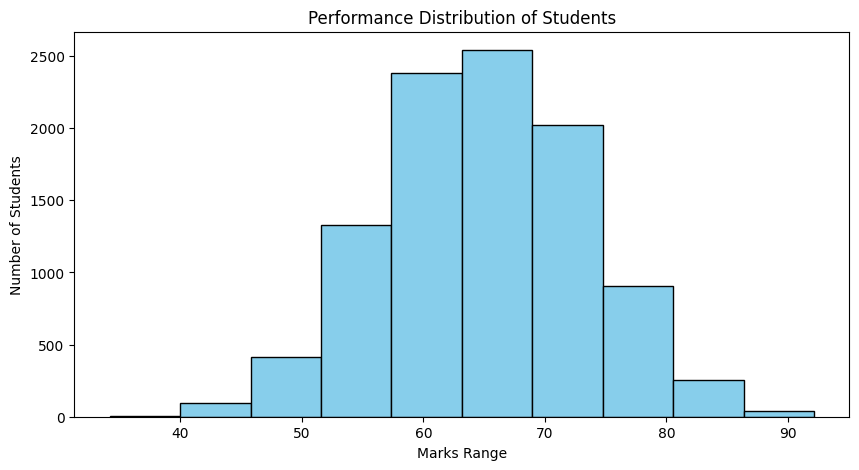

In [79]:
import matplotlib.pyplot as plt

df_pandas = df_spark.toPandas()

plt.figure(figsize=(10, 5))
plt.hist(df_pandas["Average_Marks"], bins=10, color="skyblue", edgecolor="black")
plt.xlabel("Marks Range")
plt.ylabel("Number of Students")
plt.title("Performance Distribution of Students")
plt.show()

# Find Top & Bottom Performing Subjects

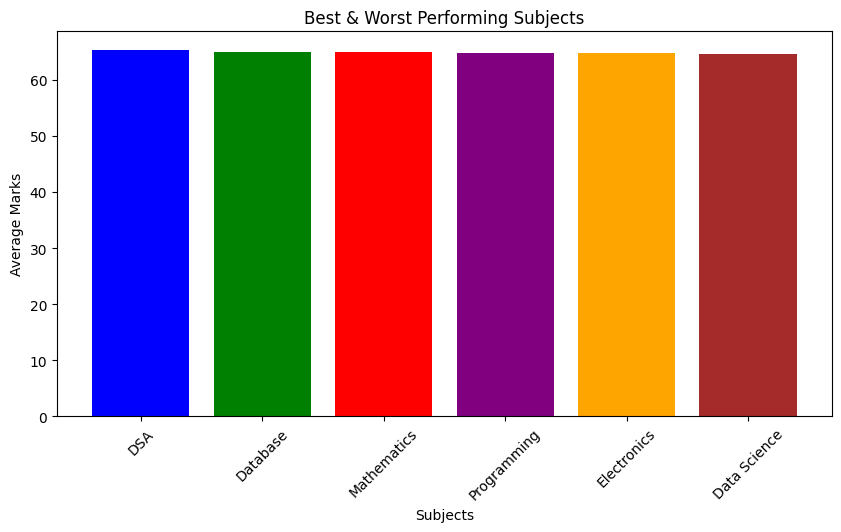

In [80]:
from pyspark.sql.functions import mean

subject_avg = df_spark.select([mean(col(subject)).alias(subject) for subject in subjects])

subject_avg_pandas = subject_avg.toPandas().T
subject_avg_pandas.columns = ["Average_Marks"]

subject_avg_pandas = subject_avg_pandas.sort_values(by="Average_Marks", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(subject_avg_pandas.index, subject_avg_pandas["Average_Marks"], color=['blue', 'green', 'red', 'purple', 'orange', 'brown'])
plt.xlabel("Subjects")
plt.ylabel("Average Marks")
plt.title("Best & Worst Performing Subjects")
plt.xticks(rotation=45)
plt.show()

# Subject-Wise Pass/Fail Rate

In [81]:
from pyspark.sql.functions import count

pass_fail_summary = df_spark.select(
    *[
        (count(when(col(subject) >= 40, subject)) / df_spark.count() * 100).alias(f"{subject}_Pass_Percentage")
        for subject in subjects
    ]
)

pass_fail_summary.show()

+---------------------------+---------------------------+------------------------+----------------------------+---------------------------+-------------------+
|Electronics_Pass_Percentage|Programming_Pass_Percentage|Database_Pass_Percentage|Data Science_Pass_Percentage|Mathematics_Pass_Percentage|DSA_Pass_Percentage|
+---------------------------+---------------------------+------------------------+----------------------------+---------------------------+-------------------+
|                      85.49|                      85.59|                   85.55|                       85.66|                      86.27|              86.29|
+---------------------------+---------------------------+------------------------+----------------------------+---------------------------+-------------------+



# Distribution of Grades (Bar Chart)

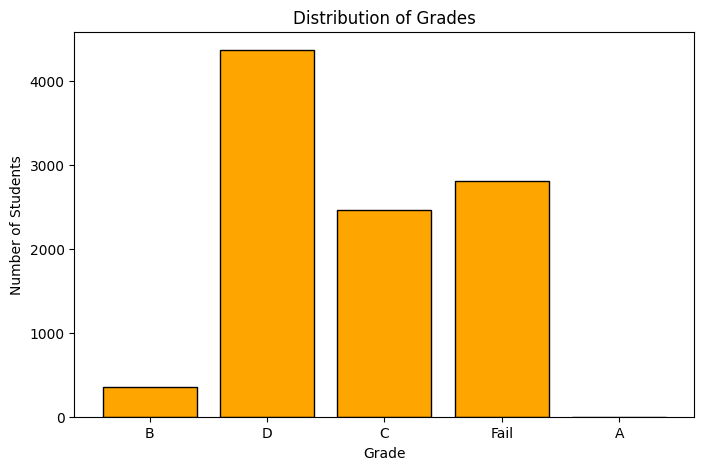

In [82]:
import matplotlib.pyplot as plt

grade_distribution = df_spark.groupBy("Grade").count().toPandas()

plt.figure(figsize=(8, 5))
plt.bar(grade_distribution["Grade"], grade_distribution["count"], color="orange", edgecolor="black")
plt.xlabel("Grade")
plt.ylabel("Number of Students")
plt.title("Distribution of Grades")
plt.show()


# Student Performance Trend (Box Plot)

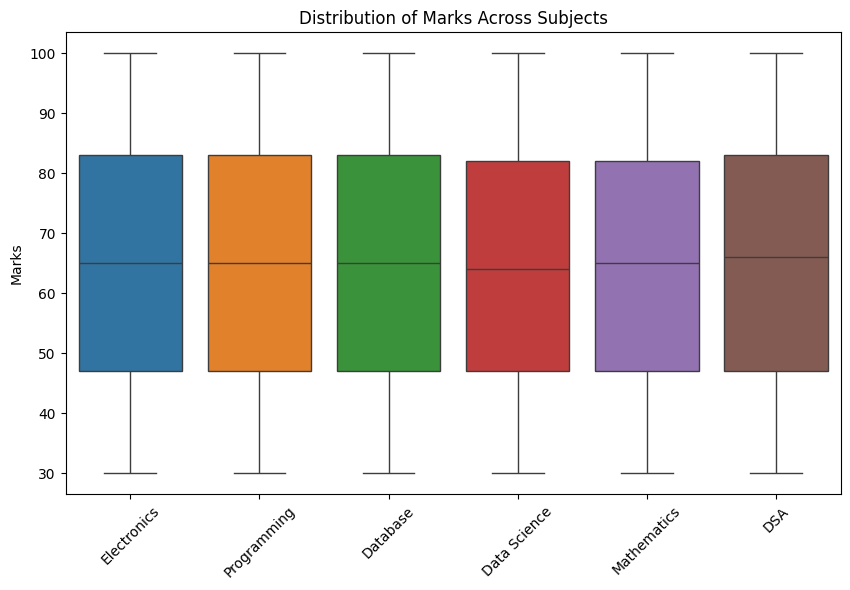

In [83]:
import seaborn as sns

df_pandas = df_spark.select(*subjects).toPandas()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_pandas)
plt.title("Distribution of Marks Across Subjects")
plt.ylabel("Marks")
plt.xticks(rotation=45)
plt.show()


# Top 10 Best Performing Students

In [84]:
df_spark.orderBy(col("Average_Marks").desc()).select("StudentID", "Name", "Average_Marks").show(10)


+---------+----------------+-----------------+
|StudentID|            Name|    Average_Marks|
+---------+----------------+-----------------+
|     9515|    Ananya Singh|92.16666666666667|
|     6476|    Robert Scott|90.16666666666667|
|     1122|     Ananya Nair|             89.5|
|     5969|     Aarav Reddy|             89.5|
|     9058|      Karan Iyer|89.16666666666667|
|     7249| Douglas Marquez|88.83333333333333|
|     7309|    Hannah Smith|             88.5|
|     6685|Nicholas Randall|88.33333333333333|
|     6939| Siddharth Patel|88.33333333333333|
|      749|     Amber Moore|88.16666666666667|
+---------+----------------+-----------------+
only showing top 10 rows



# Top 10 Weakest Performing Students

In [85]:
df_spark.orderBy(col("Average_Marks").asc()).select("StudentID", "Name", "Average_Marks").show(10)


+---------+---------------+------------------+
|StudentID|           Name|     Average_Marks|
+---------+---------------+------------------+
|     1909|    Rahul Verma|34.166666666666664|
|     4101|Michael Bradley|37.333333333333336|
|     3654| Riya Choudhary|              38.5|
|     7493|   Priya Sharma|38.833333333333336|
|     3025|   Aditya Patel|39.166666666666664|
|     4700|    Aarav Gupta|39.166666666666664|
|     9591|   Ananya Mehta|              39.5|
|     9038|      John Diaz|39.833333333333336|
|     4461|   Dylan Lawson|40.166666666666664|
|     6289|    Aditya Nair|40.333333333333336|
+---------+---------------+------------------+
only showing top 10 rows



# Identifying Outliers in Performance

In [86]:
from pyspark.sql.functions import stddev

stats = df_spark.select(mean(col("Average_Marks")).alias("Mean"), stddev(col("Average_Marks")).alias("StdDev")).collect()

mean_marks = stats[0]["Mean"]
std_dev = stats[0]["StdDev"]

high_outliers = df_spark.filter(col("Average_Marks") > mean_marks + 2 * std_dev)
low_outliers = df_spark.filter(col("Average_Marks") < mean_marks - 2 * std_dev)

print("Top Outliers (Exceptional Performers):")
high_outliers.select("StudentID", "Name", "Average_Marks").show(5)

print("Low Outliers (Poor Performers):")
low_outliers.select("StudentID", "Name", "Average_Marks").show(5)


Top Outliers (Exceptional Performers):
+---------+---------------+-----------------+
|StudentID|           Name|    Average_Marks|
+---------+---------------+-----------------+
|       23|Michael Gardner|             82.5|
|       26|    Pamela Clay|             83.0|
|       38|   Karan Sharma|85.66666666666667|
|       52|    Riya Sharma|             83.0|
|      152|    Priya Gupta|86.83333333333333|
+---------+---------------+-----------------+
only showing top 5 rows

Low Outliers (Poor Performers):
+---------+-------------------+------------------+
|StudentID|               Name|     Average_Marks|
+---------+-------------------+------------------+
|        6|         James Ward|47.666666666666664|
|       45|       Aditya Gupta|              42.5|
|       65|        Rahul Reddy|              46.5|
|       93|      Kelly Robbins|43.833333333333336|
|       98|Siddharth Choudhary|              44.0|
+---------+-------------------+------------------+
only showing top 5 rows



# Subject-Wise Standard Deviation (Performance Variability)

In [87]:
subject_variability = df_spark.select([stddev(col(subject)).alias(subject) for subject in subjects])

subject_variability.show()

+------------------+------------------+------------------+------------------+------------------+------------------+
|       Electronics|       Programming|          Database|      Data Science|       Mathematics|               DSA|
+------------------+------------------+------------------+------------------+------------------+------------------+
|20.670626435348364|20.580637525939192|20.645226605153976|20.459197335808735|20.326537853852823|20.507023248395924|
+------------------+------------------+------------------+------------------+------------------+------------------+

